In [1]:
import pkg_resources
# following versions need to be installed
pkg_resources.require('ete3==3.1.1', 'pandas==0.23.4', 'numpy==1.18.5', 'scipy==1.1.0', 'scikit-learn==0.19.1',
                      'tensorflow==1.13.1', 'joblib==0.13.2', 'h5py==2.10.0', 'Keras==2.3.1', 'matplotlib==3.1.3')


import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import tensorflow as tf
import keras
import numpy as np

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Activation, Dense

from keras.utils.training_utils import multi_gpu_model
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Dense, Dropout
from keras.layers.core import Dense, Dropout, Activation, Flatten


Using TensorFlow backend.


In [2]:
#Reading of the input data, features (Laplacian Spectrums) and parameters
cutoff=1000000 #all

param_train = pd.read_csv('../../../results_eBDM_vs3_200_500_tips/csv_for_train.csv', nrows=cutoff, index_col=0)
param_test = pd.read_csv('../../../results_eBDM_vs3_200_500_tips/csv_parameters_for_test.csv', index_col=0)
# parameter of interest: diversification rate
param_train['diversification_rate'] = param_train['birth_rate'] - param_train['extinction_rate']
param_test['diversification_rate'] = param_test['birth_rate'] - param_test['extinction_rate']

def rename_columns(df, names):
    df = df.rename(columns={i: names[i-1] for i in df.columns})
    return df

#param_train = rename_columns(param_train, column_names)
#param_test = rename_columns(param_test, column_names)

# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height
# 1 value for tree height and 500 values for internal node heights
# + 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)
encoding_train = pd.read_csv('../../../results_eBDM_vs3_200_500_tips/full_tree_rescaled_turnover_001_1/eBDM_200_500_turnover_001_1_train/longest_vs1_data.csv', sep="\t", header=None, nrows=cutoff, index_col=0)
encoding_test = pd.read_csv('../../../results_eBDM_vs3_200_500_tips/full_tree_rescaled_turnover_001_1/eBDM_200_500_turnover_001_1_test/longest_vs1_data.csv', sep="\t", header=None, index_col=0)

#indexes:
encoding_train.index = param_train.index
encoding_test.index = param_test.index

expname='_1000000_ffnn_cdv_mae'
chemin = 'full_tree/all_samp_input/'

In [3]:
print(param_train)
print(encoding_train)

         turnover_rate  birth_rate  extinction_rate  sampling_frac   R_nought  \
1                                                                               
2             0.874882    0.381373         0.333656       0.361261   1.143011   
3             0.125277    0.132268         0.016570       0.919645   7.982286   
4             0.587013    0.169996         0.099790       0.183107   1.703540   
5             0.691069    0.179670         0.124164       0.349816   1.447034   
6             0.125938    0.392451         0.049425       0.076036   7.940411   
7             0.278887    0.179020         0.049926       0.615671   3.585686   
8             0.216952    0.328559         0.071282       0.756440   4.609313   
9             0.195952    0.106037         0.020778       0.634376   5.103299   
10            0.808256    0.492445         0.398022       0.025604   1.237232   
11            0.909619    0.186279         0.169443       0.716155   1.099362   
12            0.186280    0.

In [4]:
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor

param_train['norm_factor'] = encoding_train.iloc[:,-1]
# rescale target values
encoding_train = encoding_train.drop(encoding_train.columns[-1], axis =1)
param_train['birth_rate_rescaled'] = param_train['birth_rate']*param_train['norm_factor']
param_train['extinction_rate_rescaled'] = param_train['extinction_rate']*param_train['norm_factor']
param_train['diversification_rate_resc'] = param_train['diversification_rate']*param_train['norm_factor']

### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test.iloc[:,-1]
# rescale target values
encoding_test = encoding_test.drop(encoding_test.columns[-1], axis =1)
param_test['birth_rate_rescaled'] = param_test['birth_rate']*param_test['norm_factor']
param_test['extinction_rate_rescaled'] = param_test['extinction_rate']*param_test['norm_factor']
param_test['diversification_rate_resc'] = param_test['diversification_rate']*param_test['norm_factor']


#Choice of the parameters to predict
target_1 = "birth_rate_rescaled"
target_2 = "extinction_rate_rescaled"
target_3 = "turnover_rate"
target_4 = "diversification_rate_resc"
targets = pd.DataFrame(param_train[[target_1, target_2, target_3, target_4]])
targets_test = pd.DataFrame(param_test[[target_1, target_2, target_3, target_4]])


#Choice of the features: in this case, all the lines
features = encoding_train
features_test = encoding_test
valid_set_nb = 10000

In [5]:
#Add the known sampling fraction into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = pd.DataFrame(param_train[add_target])
features['1001'] = added_targets

added_targets2 = pd.DataFrame(param_test[add_target])
features_test['1001'] = added_targets2


'\nadd_target = "transmission_rate"\nadded_targets = pd.DataFrame(parameters[add_target])\nfeatures[\'398\'] = added_targets\n\npredicted_transmission_rate = pd.read_csv(\'predicted_transmission_rate.csv\')\n\npredicted_transmission_rate = predicted_transmission_rate.drop(predicted_transmission_rate.columns[0], axis =1)\n\npredicted_transmission = predicted_transmission_rate.as_matrix()\n\npredicted_transmission = predicted_transmission.reshape(899855)\n\nfeatures[\'398\'][:899855] = predicted_transmission\n'

In [6]:
print(features.shape)
print(targets.shape)

valid_frac = valid_set_nb/features.shape[0]
train_size_frac = (features.shape[0]-valid_set_nb)/features.shape[0]

(1000000, 502)
(1000000, 4)


In [7]:
features

,1,2,3,4,5,6,7,8,9,10,...,493,494,495,496,497,498,499,500,501,1001
1,,,,,,,,,,,,,,,,,,,,,
2,11.700365,11.172593,10.418716,11.227841,9.991438,9.556257,9.594301,11.240674,9.482048,9.622095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361261
3,10.898345,9.110271,8.257999,9.659510,7.375813,9.563730,10.299675,9.324722,9.620378,10.601697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.919645
4,8.608306,7.136067,6.782000,7.108194,8.496636,6.706171,6.553076,7.814724,7.666936,6.914597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183107
5,13.288767,10.610986,10.867757,13.243327,9.882245,12.212116,9.591177,9.699930,11.406177,13.009605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349816
6,5.256242,3.375401,3.150304,4.740335,2.939978,2.501094,2.543208,3.650645,4.769490,2.348926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076036
7,11.898072,10.774114,10.709979,10.503580,10.711790,11.382613,10.383156,8.831830,11.532228,11.488162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615671
8,9.510212,8.006512,9.277536,7.608777,7.035647,8.877734,8.085061,8.833743,9.396947,7.378368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756440
9,12.730731,12.075164,11.700868,11.649638,11.620251,12.239691,11.894291,11.544252,11.776421,10.009469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634376
10,6.950933,5.560178,5.187938,4.450743,5.784711,4.315216,4.004111,5.513813,4.773289,3.617524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025604


In [8]:
X = features
Y = targets


X_test = features_test
Y_test = targets_test

In [9]:
print(features.shape)

(1000000, 502)


In [10]:
X.shape[1]

502

In [11]:
#Creation of the Network Model: model definition

def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(32, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(16, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(8, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(4, activation='elu'))
    model.summary()
    return model

In [12]:
#Building of the model

from keras import losses

model = build_model()

estimator = model

#Adam optimizer, loss measure: mean absolute error, metrics measured: MAPE
estimator.compile(loss='mae', optimizer = 'Adam', metrics=[losses.mean_absolute_percentage_error])

#early stopping to avoid overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

#display training progress for each completed epoch.
class PrintD(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# maximum number of EPOCHS, ie full training cycles on the whole training dataset (how many times we see the same training set)
EPOCHS = 10000

#Training of the Network, with an independent validation set
history = estimator.fit(X, Y, verbose = 1, epochs=EPOCHS, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintD()])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                32192     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
Total params: 34,972
Trainable params: 34,972
Non-trainable params: 0
_________________________________________________________________
Train on 990000 samples, validate on 10000 samples
Epoch 1/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.47

.Epoch 37/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.2296 - mean_absolute_percentage_error: 66.6850 - val_loss: 0.2638 - val_mean_absolute_percentage_error: 57.4659
.Epoch 38/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.2271 - mean_absolute_percentage_error: 66.4774 - val_loss: 0.2082 - val_mean_absolute_percentage_error: 58.2110
.Epoch 39/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.2216 - mean_absolute_percentage_error: 65.1868 - val_loss: 0.2131 - val_mean_absolute_percentage_error: 52.3739
.Epoch 40/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.2388 - mean_absolute_percentage_error: 69.6241 - val_loss: 0.1957 - val_mean_absolute_percentage_error: 65.6354
.Epoch 41/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.2339 - mean_absolute_percentage_error: 68.5529 - val_loss: 0.1971 - val_mean_absolute_percentage_error: 62.4246
.Epoc

990000/990000 [==============================] - 8s 8us/step - loss: 0.2079 - mean_absolute_percentage_error: 62.9530 - val_loss: 0.1765 - val_mean_absolute_percentage_error: 59.6532
.Epoch 120/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1937 - mean_absolute_percentage_error: 59.4867 - val_loss: 0.1894 - val_mean_absolute_percentage_error: 52.0537
.Epoch 121/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1884 - mean_absolute_percentage_error: 58.5534 - val_loss: 0.1715 - val_mean_absolute_percentage_error: 56.8199
.Epoch 122/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.2010 - mean_absolute_percentage_error: 60.9294 - val_loss: 0.1923 - val_mean_absolute_percentage_error: 62.5095
.Epoch 123/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1921 - mean_absolute_percentage_error: 59.1508 - val_loss: 0.1723 - val_mean_absolute_percentage_error: 58.7253
.Epoch 124/10000


990000/990000 [==============================] - 7s 8us/step - loss: 0.1876 - mean_absolute_percentage_error: 58.6593 - val_loss: 0.1712 - val_mean_absolute_percentage_error: 57.6474
.Epoch 161/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1980 - mean_absolute_percentage_error: 60.4428 - val_loss: 0.1946 - val_mean_absolute_percentage_error: 57.5506
.Epoch 162/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1836 - mean_absolute_percentage_error: 58.5440 - val_loss: 0.1763 - val_mean_absolute_percentage_error: 54.0917
.Epoch 163/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1953 - mean_absolute_percentage_error: 59.5626 - val_loss: 0.1698 - val_mean_absolute_percentage_error: 53.4078
.Epoch 164/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1856 - mean_absolute_percentage_error: 58.1776 - val_loss: 0.1718 - val_mean_absolute_percentage_error: 51.8469
.Epoch 165/10000


990000/990000 [==============================] - 7s 8us/step - loss: 0.1808 - mean_absolute_percentage_error: 57.5564 - val_loss: 0.1665 - val_mean_absolute_percentage_error: 53.7350

.Epoch 202/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1899 - mean_absolute_percentage_error: 59.3556 - val_loss: 0.1898 - val_mean_absolute_percentage_error: 62.9851
.Epoch 203/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1764 - mean_absolute_percentage_error: 56.8619 - val_loss: 0.2107 - val_mean_absolute_percentage_error: 52.0580
.Epoch 204/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1828 - mean_absolute_percentage_error: 57.8793 - val_loss: 0.1675 - val_mean_absolute_percentage_error: 57.5942
.Epoch 205/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1854 - mean_absolute_percentage_error: 58.0807 - val_loss: 0.1766 - val_mean_absolute_percentage_error: 63.4652
.Epoch 206/10000

990000/990000 [==============================] - 7s 8us/step - loss: 0.1728 - mean_absolute_percentage_error: 56.2775 - val_loss: 0.1888 - val_mean_absolute_percentage_error: 67.1447
.Epoch 243/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1843 - mean_absolute_percentage_error: 58.0243 - val_loss: 0.1663 - val_mean_absolute_percentage_error: 54.0817
.Epoch 244/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1768 - mean_absolute_percentage_error: 56.6024 - val_loss: 0.2329 - val_mean_absolute_percentage_error: 80.1553
.Epoch 245/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1768 - mean_absolute_percentage_error: 56.9108 - val_loss: 0.1804 - val_mean_absolute_percentage_error: 52.9446
.Epoch 246/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1766 - mean_absolute_percentage_error: 56.7980 - val_loss: 0.1649 - val_mean_absolute_percentage_error: 54.4479
.Epoch 247/10000


990000/990000 [==============================] - 7s 8us/step - loss: 0.1738 - mean_absolute_percentage_error: 56.3045 - val_loss: 0.1683 - val_mean_absolute_percentage_error: 56.7085
.Epoch 284/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1705 - mean_absolute_percentage_error: 55.8215 - val_loss: 0.1839 - val_mean_absolute_percentage_error: 48.9279
.Epoch 285/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1754 - mean_absolute_percentage_error: 56.5122 - val_loss: 0.1641 - val_mean_absolute_percentage_error: 56.0085
.Epoch 286/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1750 - mean_absolute_percentage_error: 56.4688 - val_loss: 0.1648 - val_mean_absolute_percentage_error: 52.9094
.Epoch 287/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1793 - mean_absolute_percentage_error: 57.2436 - val_loss: 0.1716 - val_mean_absolute_percentage_error: 57.9839
.Epoch 288/10000


990000/990000 [==============================] - 8s 8us/step - loss: 0.1690 - mean_absolute_percentage_error: 55.4933 - val_loss: 0.1637 - val_mean_absolute_percentage_error: 54.8995
.Epoch 325/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1728 - mean_absolute_percentage_error: 55.9043 - val_loss: 0.1793 - val_mean_absolute_percentage_error: 51.6510
.Epoch 326/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1707 - mean_absolute_percentage_error: 55.7574 - val_loss: 0.1635 - val_mean_absolute_percentage_error: 53.8862
.Epoch 327/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1768 - mean_absolute_percentage_error: 56.7859 - val_loss: 0.1996 - val_mean_absolute_percentage_error: 67.5991
.Epoch 328/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1747 - mean_absolute_percentage_error: 56.1638 - val_loss: 0.1761 - val_mean_absolute_percentage_error: 65.1327
.Epoch 329/10000


990000/990000 [==============================] - 7s 8us/step - loss: 0.1675 - mean_absolute_percentage_error: 55.2310 - val_loss: 0.1628 - val_mean_absolute_percentage_error: 53.3435
.Epoch 366/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1700 - mean_absolute_percentage_error: 55.4487 - val_loss: 0.1678 - val_mean_absolute_percentage_error: 56.5332
.Epoch 367/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1691 - mean_absolute_percentage_error: 55.5931 - val_loss: 0.1687 - val_mean_absolute_percentage_error: 57.0246
.Epoch 368/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1737 - mean_absolute_percentage_error: 56.0238 - val_loss: 0.1665 - val_mean_absolute_percentage_error: 52.8574
.Epoch 369/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1710 - mean_absolute_percentage_error: 55.5285 - val_loss: 0.1627 - val_mean_absolute_percentage_error: 54.3475
.Epoch 370/10000


990000/990000 [==============================] - 8s 8us/step - loss: 0.1692 - mean_absolute_percentage_error: 55.7497 - val_loss: 0.1654 - val_mean_absolute_percentage_error: 51.2836
.Epoch 407/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1744 - mean_absolute_percentage_error: 56.2942 - val_loss: 0.1693 - val_mean_absolute_percentage_error: 51.4454
.Epoch 408/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1711 - mean_absolute_percentage_error: 55.5914 - val_loss: 0.1663 - val_mean_absolute_percentage_error: 58.2773
.Epoch 409/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1681 - mean_absolute_percentage_error: 55.0279 - val_loss: 0.1658 - val_mean_absolute_percentage_error: 58.0013
.Epoch 410/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1726 - mean_absolute_percentage_error: 55.8732 - val_loss: 0.1729 - val_mean_absolute_percentage_error: 58.5512
.Epoch 411/10000


990000/990000 [==============================] - 8s 8us/step - loss: 0.1743 - mean_absolute_percentage_error: 56.2875 - val_loss: 0.1804 - val_mean_absolute_percentage_error: 54.5840
.Epoch 448/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1698 - mean_absolute_percentage_error: 55.3436 - val_loss: 0.1905 - val_mean_absolute_percentage_error: 50.4186
.Epoch 449/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1619 - mean_absolute_percentage_error: 54.3310 - val_loss: 0.1616 - val_mean_absolute_percentage_error: 54.8901
.Epoch 450/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1640 - mean_absolute_percentage_error: 54.4664 - val_loss: 0.1853 - val_mean_absolute_percentage_error: 50.4536
.Epoch 451/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1700 - mean_absolute_percentage_error: 55.2484 - val_loss: 0.1685 - val_mean_absolute_percentage_error: 51.8937
.Epoch 452/10000


990000/990000 [==============================] - 7s 8us/step - loss: 0.1668 - mean_absolute_percentage_error: 54.8669 - val_loss: 0.1715 - val_mean_absolute_percentage_error: 58.0853
.Epoch 489/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1673 - mean_absolute_percentage_error: 54.9359 - val_loss: 0.1662 - val_mean_absolute_percentage_error: 50.8791
.Epoch 490/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1689 - mean_absolute_percentage_error: 54.9165 - val_loss: 0.1667 - val_mean_absolute_percentage_error: 51.5732
.Epoch 491/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1654 - mean_absolute_percentage_error: 54.7004 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 54.8082
.Epoch 492/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1671 - mean_absolute_percentage_error: 54.8508 - val_loss: 0.1633 - val_mean_absolute_percentage_error: 56.1042
.Epoch 493/10000


990000/990000 [==============================] - 7s 8us/step - loss: 0.1650 - mean_absolute_percentage_error: 54.5677 - val_loss: 0.1642 - val_mean_absolute_percentage_error: 51.8528
.Epoch 530/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1670 - mean_absolute_percentage_error: 54.9856 - val_loss: 0.1704 - val_mean_absolute_percentage_error: 58.0585
.Epoch 531/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1651 - mean_absolute_percentage_error: 54.5324 - val_loss: 0.1829 - val_mean_absolute_percentage_error: 46.7739
.Epoch 532/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1632 - mean_absolute_percentage_error: 54.2690 - val_loss: 0.2174 - val_mean_absolute_percentage_error: 71.1416
.Epoch 533/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1708 - mean_absolute_percentage_error: 55.8576 - val_loss: 0.1733 - val_mean_absolute_percentage_error: 60.2875
.Epoch 534/10000


990000/990000 [==============================] - 8s 8us/step - loss: 0.1587 - mean_absolute_percentage_error: 53.6505 - val_loss: 0.1608 - val_mean_absolute_percentage_error: 52.9585
.Epoch 571/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1649 - mean_absolute_percentage_error: 54.5215 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 52.4257
.Epoch 572/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1626 - mean_absolute_percentage_error: 54.0865 - val_loss: 0.1647 - val_mean_absolute_percentage_error: 57.9487
.Epoch 573/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1650 - mean_absolute_percentage_error: 54.7649 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 52.6739
.Epoch 574/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1663 - mean_absolute_percentage_error: 54.6295 - val_loss: 0.1643 - val_mean_absolute_percentage_error: 56.1477
.Epoch 575/10000


990000/990000 [==============================] - 8s 8us/step - loss: 0.1597 - mean_absolute_percentage_error: 53.6855 - val_loss: 0.1689 - val_mean_absolute_percentage_error: 53.0703
.Epoch 612/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1647 - mean_absolute_percentage_error: 54.3547 - val_loss: 0.1647 - val_mean_absolute_percentage_error: 52.3280
.Epoch 613/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1627 - mean_absolute_percentage_error: 54.0915 - val_loss: 0.1694 - val_mean_absolute_percentage_error: 59.0638
.Epoch 614/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1634 - mean_absolute_percentage_error: 54.1587 - val_loss: 0.1614 - val_mean_absolute_percentage_error: 52.7711
.Epoch 615/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1644 - mean_absolute_percentage_error: 54.8209 - val_loss: 0.1728 - val_mean_absolute_percentage_error: 52.8377
.Epoch 616/10000


990000/990000 [==============================] - 8s 8us/step - loss: 0.1645 - mean_absolute_percentage_error: 54.2475 - val_loss: 0.1625 - val_mean_absolute_percentage_error: 51.6334
.Epoch 653/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1583 - mean_absolute_percentage_error: 53.4459 - val_loss: 0.1642 - val_mean_absolute_percentage_error: 52.3278
.Epoch 654/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1620 - mean_absolute_percentage_error: 53.9075 - val_loss: 0.1647 - val_mean_absolute_percentage_error: 54.4413
.Epoch 655/10000
990000/990000 [==============================] - 8s 8us/step - loss: 0.1595 - mean_absolute_percentage_error: 53.6529 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 51.3217
.Epoch 656/10000
990000/990000 [==============================] - 7s 8us/step - loss: 0.1619 - mean_absolute_percentage_error: 53.8169 - val_loss: 0.1742 - val_mean_absolute_percentage_error: 52.6957
.Epoch 657/10000


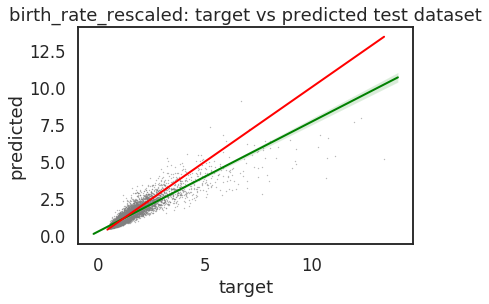

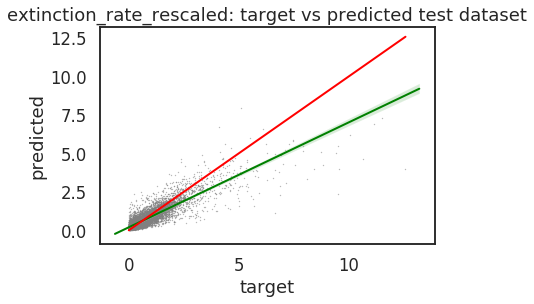

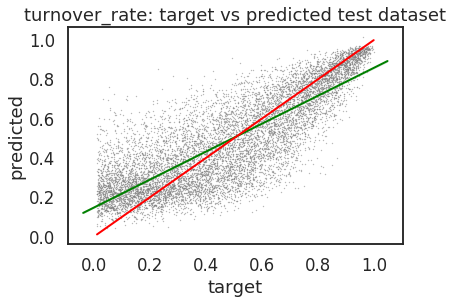

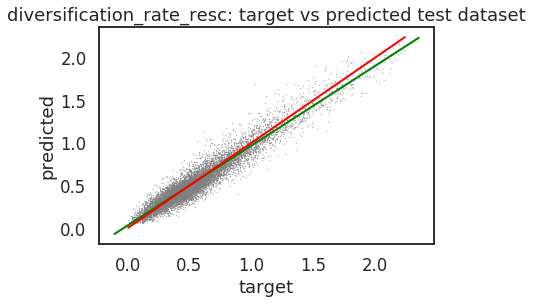

In [14]:
import seaborn as sns
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(estimator.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=2, color='red')
    plt.show()
    return None

    
for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)

In [15]:
# rescale back
predicted_test['birth_rate'] = predicted_test['birth_rate_rescaled']/param_test['norm_factor']
predicted_test['extinction_rate'] = predicted_test['extinction_rate_rescaled']/param_test['norm_factor']
predicted_test['diversification_rate'] = predicted_test['diversification_rate_resc']/param_test['norm_factor']

In [16]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)

                                MAE       RMSE       RME
birth_rate_rescaled         0.20399   0.393326  0.135952
extinction_rate_rescaled   0.264134   0.457467   1.10869
turnover_rate              0.120355    0.15589   0.83059
diversification_rate_resc  0.071411  0.0932851  0.165063


In [ ]:
#print differences between predicted and target as function of target: showing structural bias

def predicted_minus_target_vs_target(pr_m_tar_name, target_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=pr_m_tar_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs (target-predicted) test dataset')
    plt.xlabel('target')
    plt.ylabel('target - predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    
    plt.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')
    plt.show()
    return None


for elt in elts:
    predicted_minus_target_vs_target('predicted_minus_target_'+elt, 'target_'+elt, elt, file_name_beg=elt)


In [ ]:
###save the model, weights (and scaler for sumstats only)

from keras.models import model_from_json

# save model
model_trial_1000 = model.to_json()
with open('../Model/' + chemin + 'model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
model.save_weights('../Model/' + chemin + 'model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


In [19]:
####save the predicted and the target dataframes
Y_test.to_csv('../../Data/' + chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv('../../Data/' + chemin + expname + 'predicted_all.csv', header=True)

